In [1]:
# - IMPORTS ---
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
# - FUNCTIONS ---
def compute_summary_stats_for_csv_file(
    csv_f:str,
    coeff_type: str,
    filter_columns: list,
    shift_v: int
) -> pd.DataFrame:
    """
    Compute summary statistics for the given CSV file
    """
    df_table = pd.read_csv(csv_f)
    columns_oI = df_table.columns[2:-2]  # Select Only columns with numerical values
    label_columns = df_table.columns[-2:]
    df_label = df_table[label_columns]
    
    if filter_columns != []:
        columns_oI = filter_columns

    # Filter the table
    df_table_corr = df_table[df_table["Coeff"] == f"{coeff_type}_corr_coeffs"]
    df_table_p = df_table[df_table["Coeff"] == f"{coeff_type}_p_values"]
    df_table_corr_f = pd.DataFrame(df_table_corr, columns = columns_oI)     

    # Check which coefficient have a p value lover than threshold (statistically significant)
    # TODO, use as filter: mask = (df_table_p_f < p_threhsold)  
    df_table_p_f = pd.DataFrame(df_table_p, columns = columns_oI) 
    valid_df_table_corr = df_table_corr_f
    
    id_label = {"id": [], "shift": []}
    df_id_label = pd.DataFrame(id_label)
    df_label = df_label.filter(items = valid_df_table_corr.index, axis=0)
    df_id_label["id"] = df_label["sequence_name"] + "_" + df_label["obx"]
    df_id_label["shift"] = (df_id_label["id"])
    df_id_label["shift"] = shift_v
    
    new_df_table = pd.concat([valid_df_table_corr, df_id_label], axis=1)
    # new_df_table = new_df_table.sort_values(by=["sequence_name"])

    return new_df_table

# TODO: move this function in an util 
def filter_csv_files(sim_or_not, op_type, coeff_type, all_csv_files):
    check = lambda file_name, options: any(o in file_name for o in options)
    if sim_or_not != []:
        all_csv_files = [f for f in all_csv_files if check(f, sim_or_not)]
    if op_type != []:
        all_csv_files = [f for f in all_csv_files if check(f, op_type)]
    if coeff_type != []:
        all_csv_files = [f for f in all_csv_files if check(f, coeff_type)]
    return all_csv_files


def plot_heatmap(summary_table, elements):
    for elem in elements:
        pivot_df = summary_table.pivot(index='id', columns='shift', values=elem)

        fig, ax = plt.subplots(figsize=(10,15))
        sns.heatmap(pivot_df, cmap='magma_r', annot=False, ax=ax)
    
        # # Example assuming 'shift' column values are directly the column headers in pivot_df
        # shift_0_column_index = list(pivot_df.columns).index(0)  # Get the index for shift 0
        # num_sequences = len(pivot_df.index)  # Number of sequences to cover

        # # Create a rectangle patch
        # rect = patches.Rectangle((shift_0_column_index, 0), 1, num_sequences, 
        #                          linewidth=1, edgecolor='#4BFF4B', 
        #                          facecolor='none')

        # # Add the rectangle to the Axes
        # ax.add_patch(rect)
    
        plt.title(f'Heatmap of {elem} by Sequence and Shift')
        plt.xlabel('Shift')
        plt.ylabel('id')
        plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
        plt.show()

../stats_HUB/summary_stats/d17-val/shift_0/noxsim_sum_pd.csv


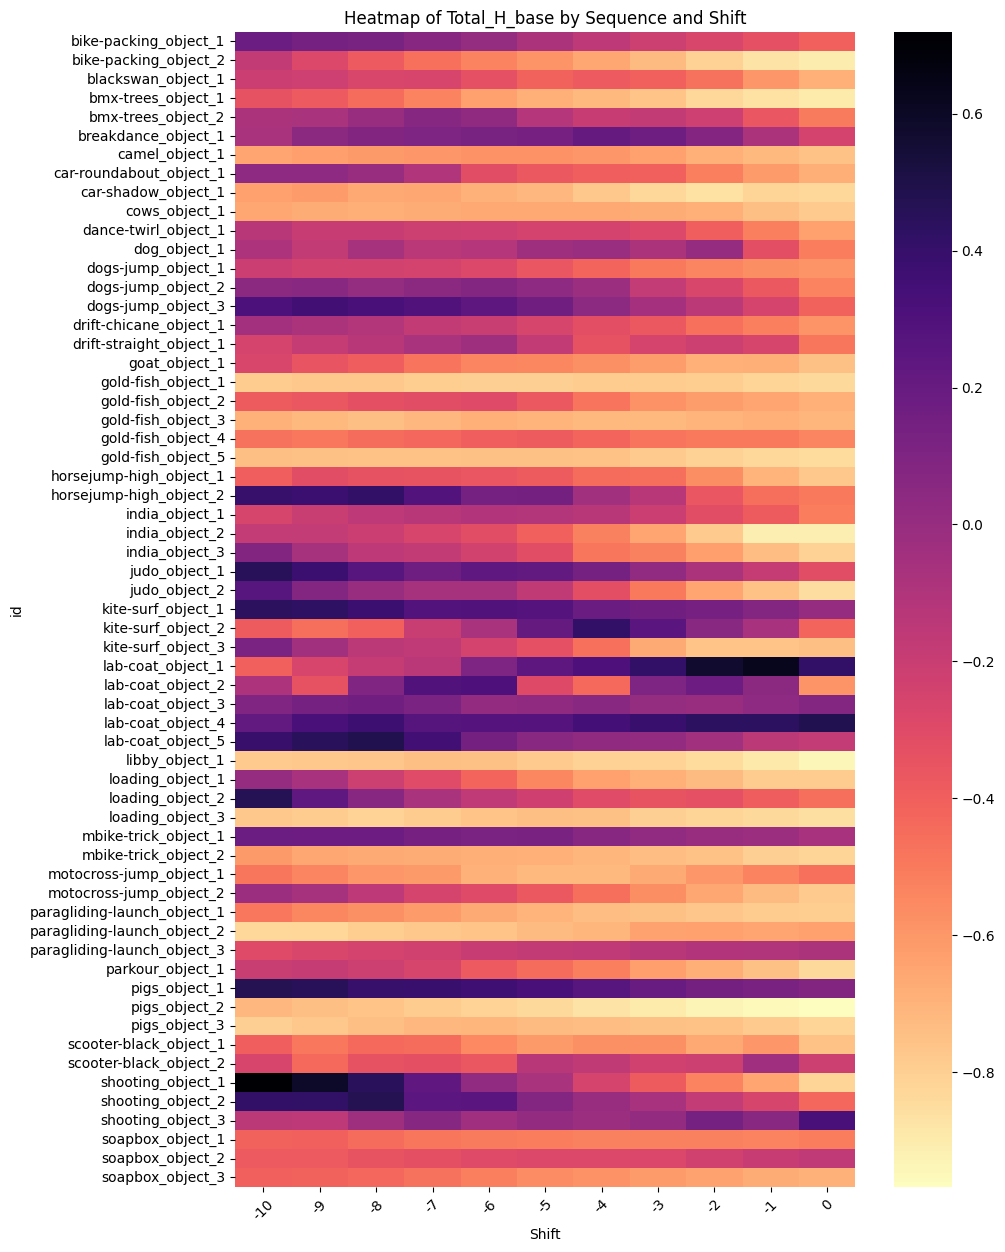

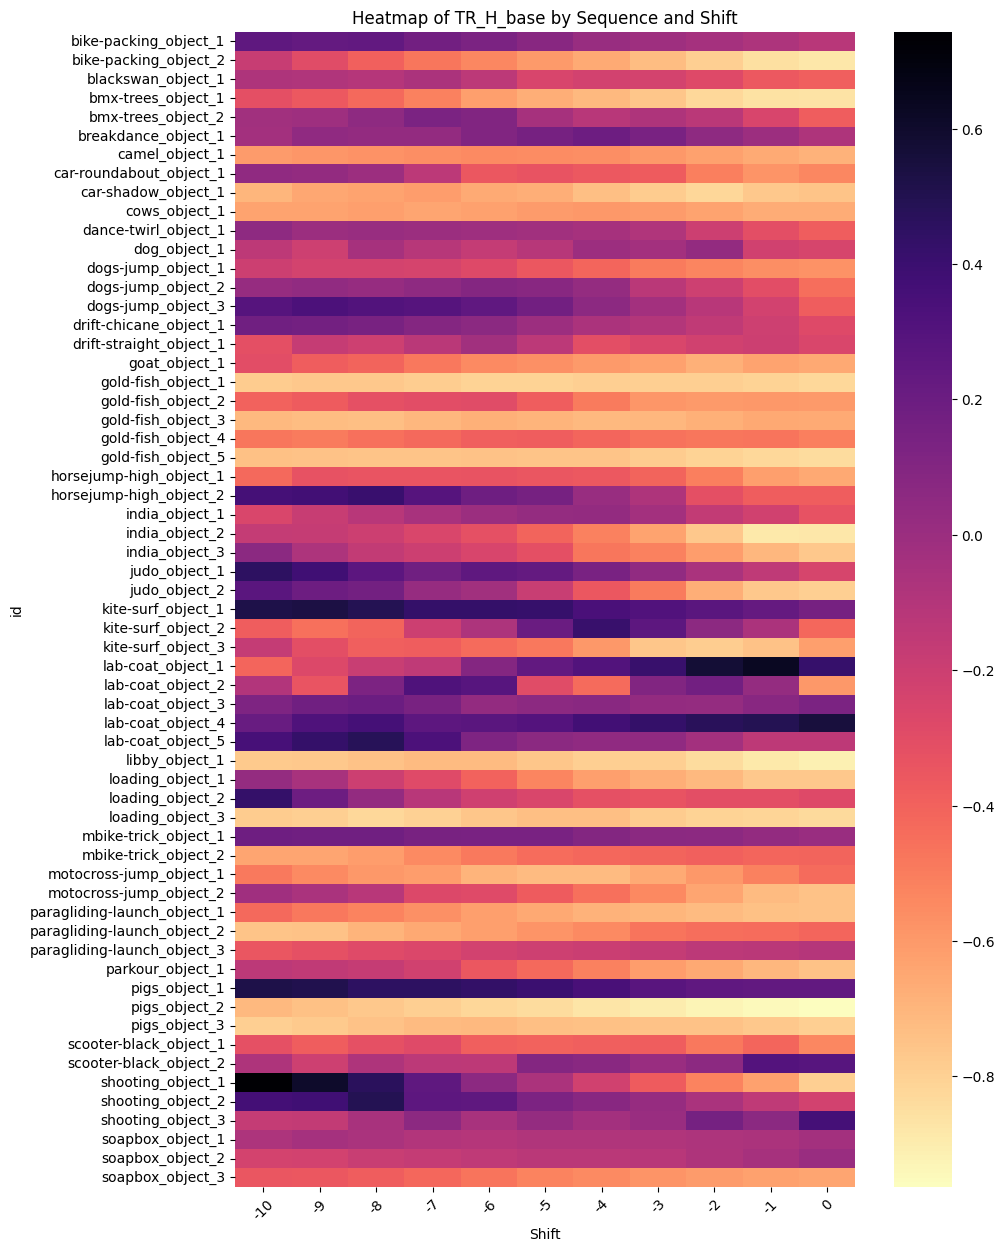

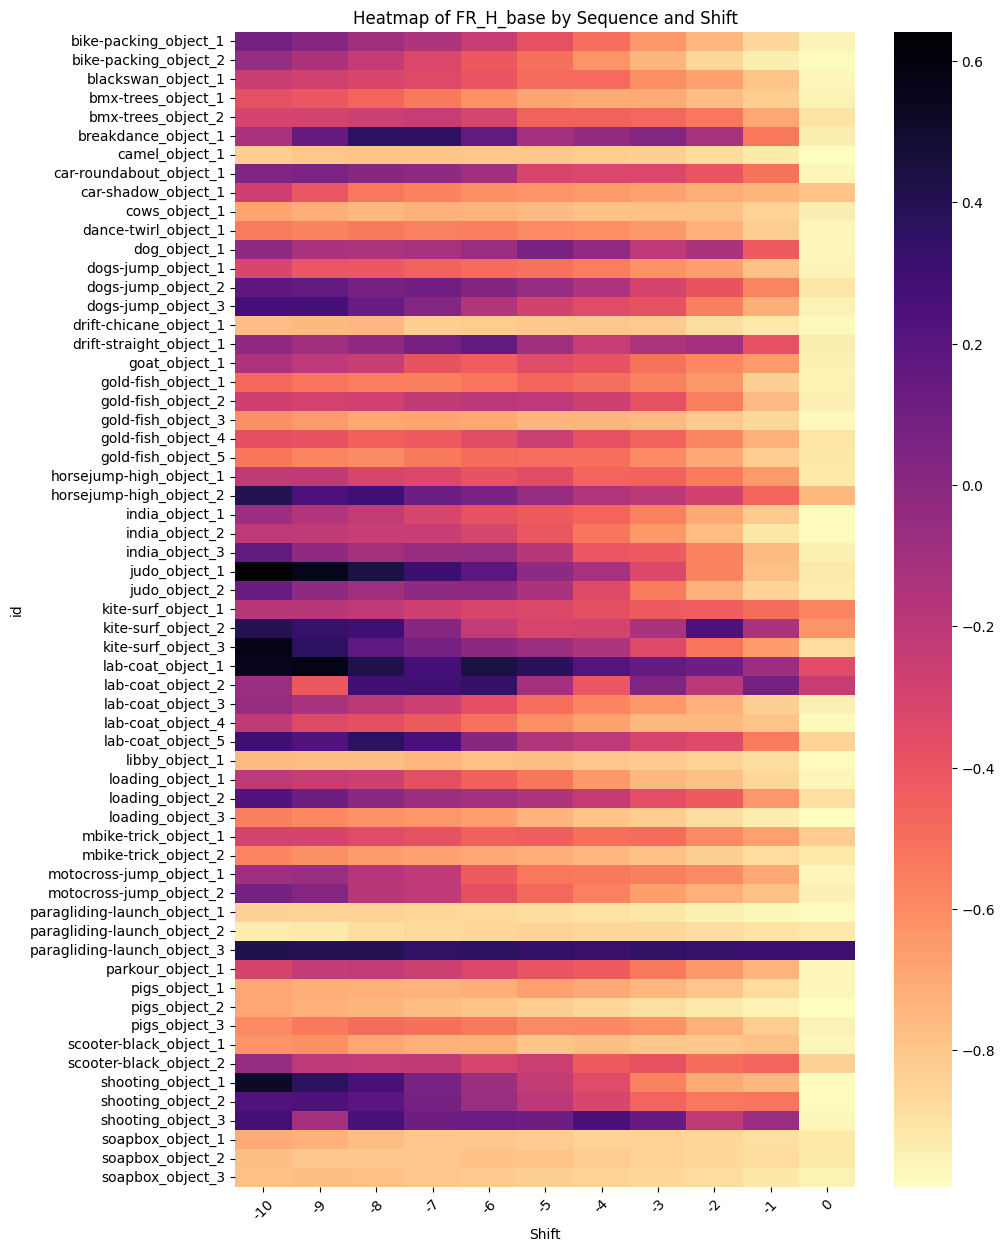

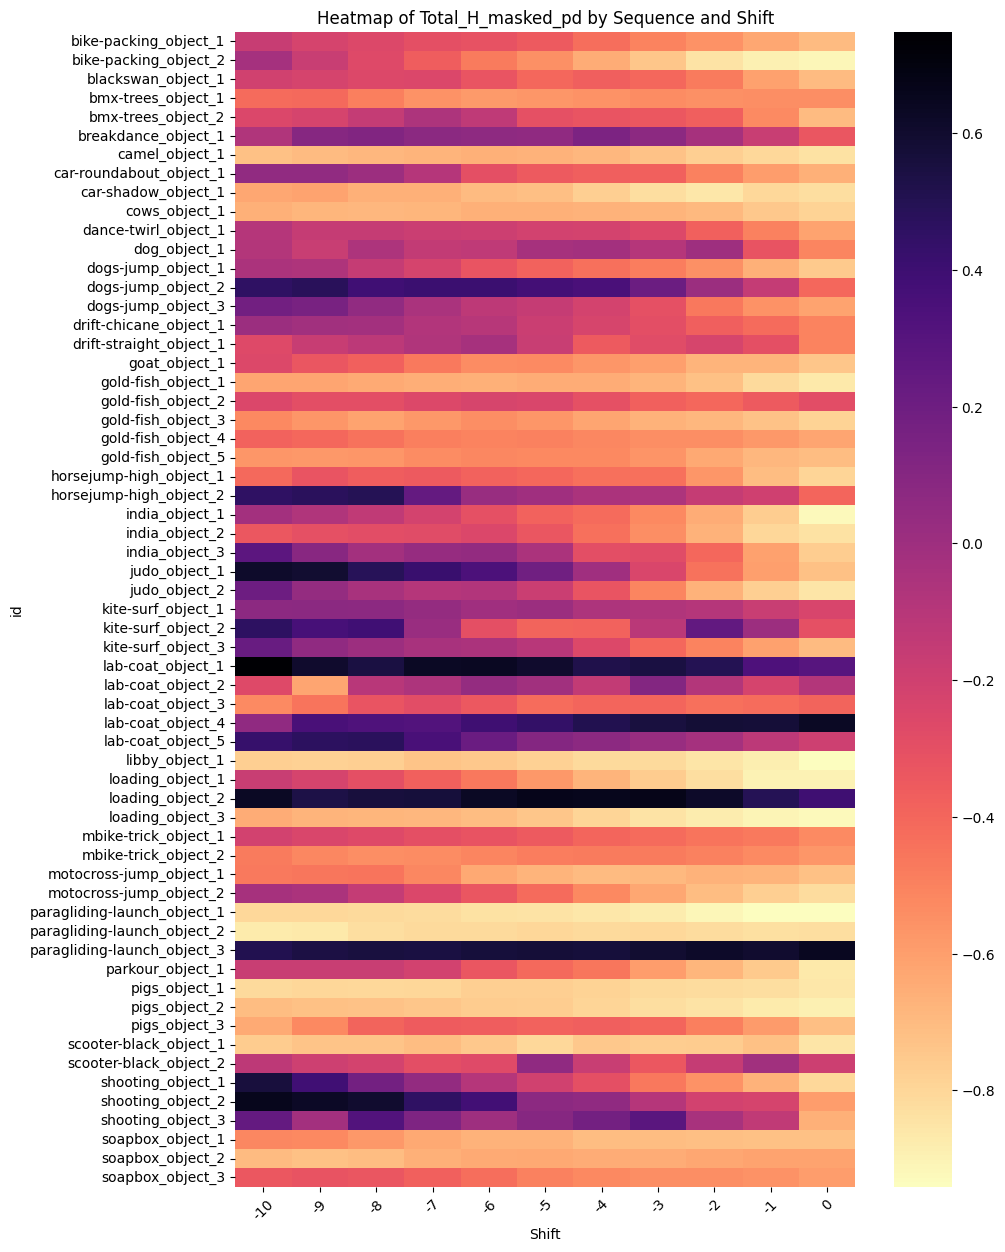

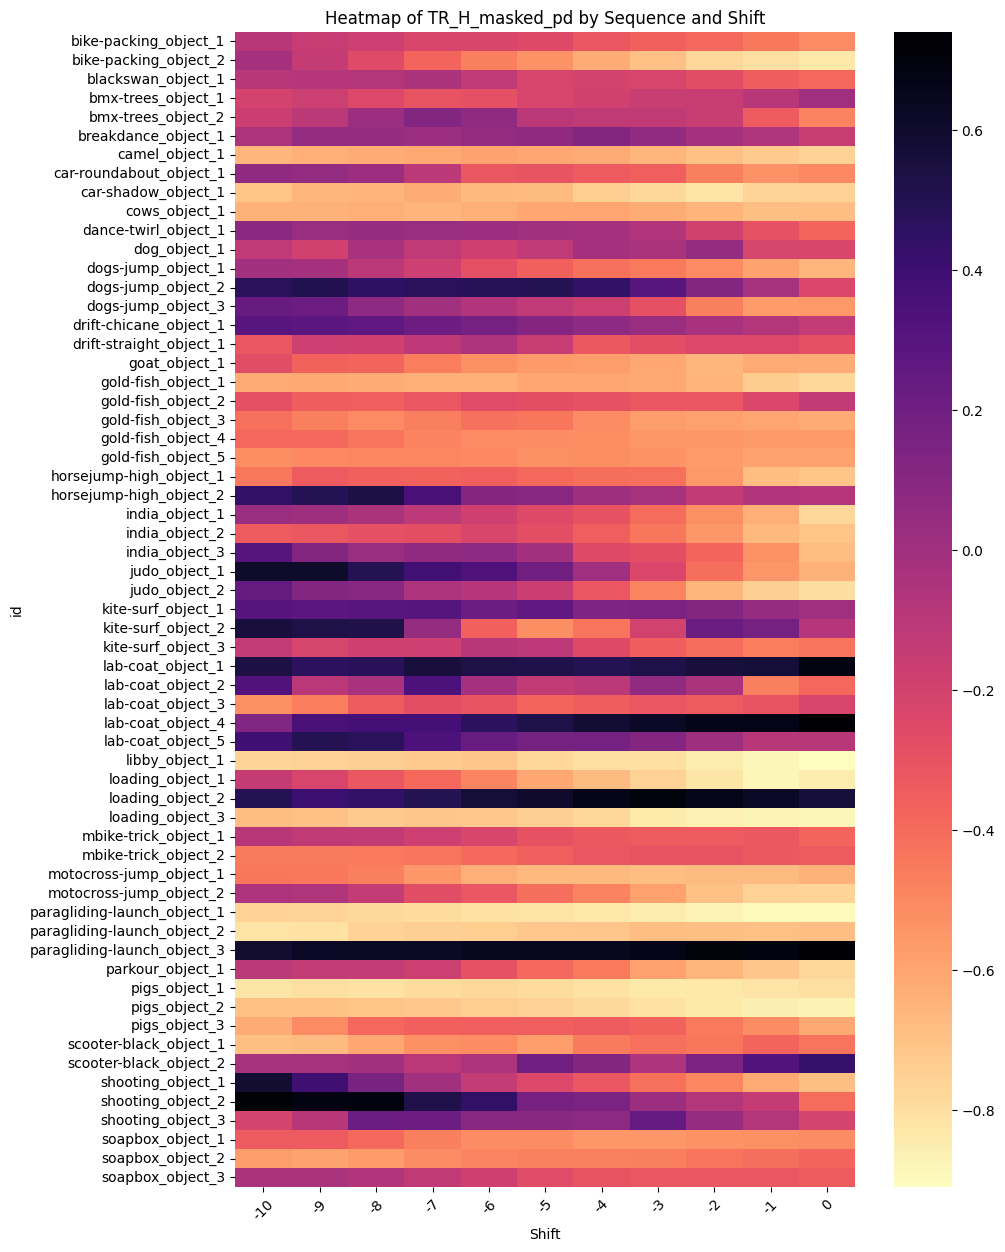

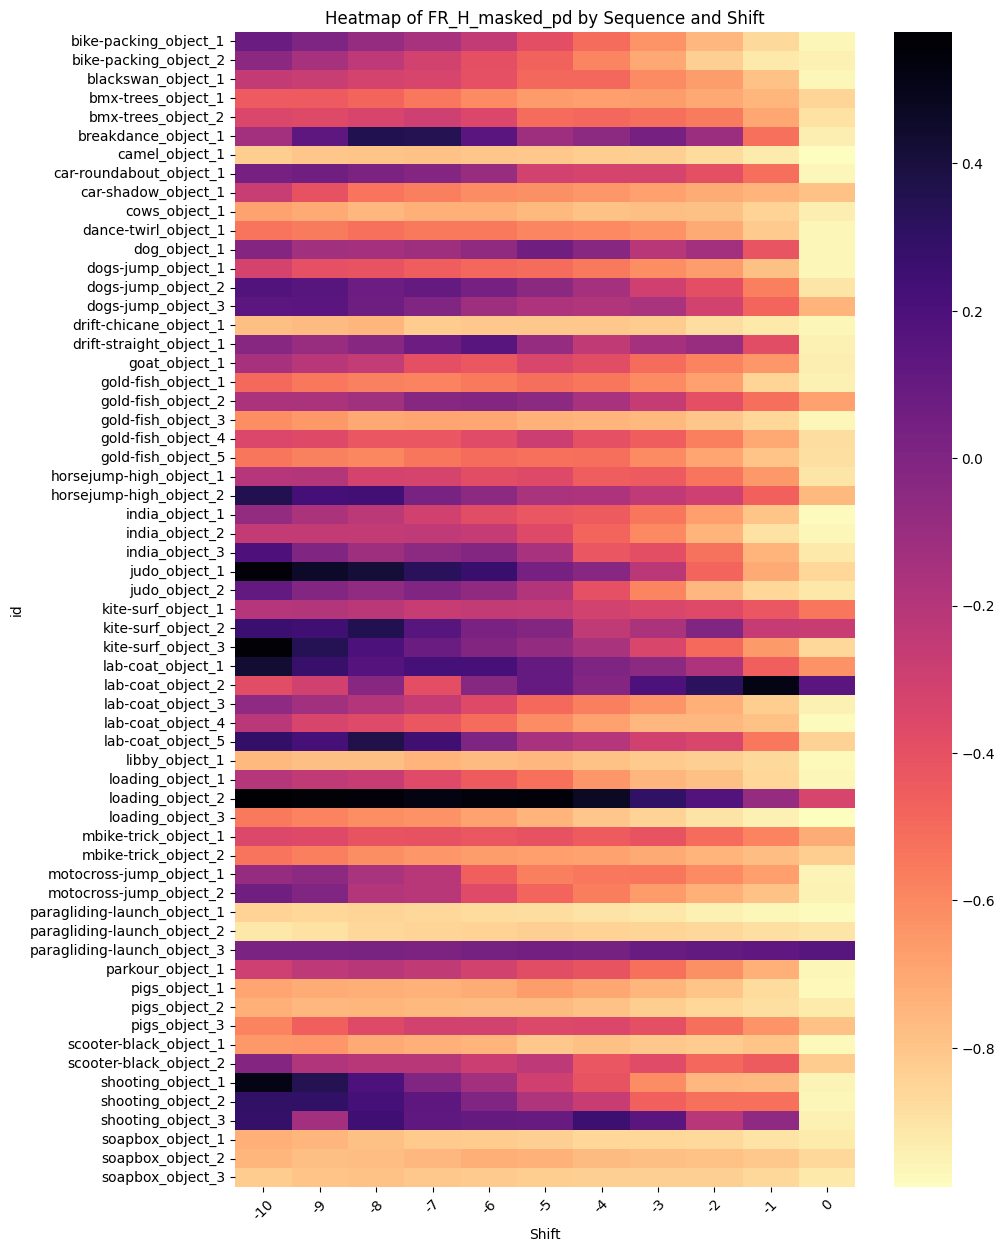

In [4]:
# - PARAMETERS ---
# TODO: Works only with one element for each filter
dataset_name = "d17-val"
stats_path = "../raw_stats_HUB/summary_stats"
sim_or_not = ['noxsim_']  # 'yexsim_', 'noxsim_'
op_type = ['_sum_']  # '_mean_', '_median_', '_sum_'
coeff_type = "spearman"  # 'spearman', 'pearson'
base = 'pd' # 'gt', 'pd'
shift_vector = np.arange(-10,1)

focus_on_columns = ["Total_H_base", "TR_H_base", "FR_H_base",
                    # "Total_H_masked_gt", "TR_H_masked_gt", "FR_H_masked_gt",
                    "Total_H_masked_pd", "TR_H_masked_pd", "FR_H_masked_pd"]

# - MAIN ---
for idx, shift in enumerate(shift_vector):
    shift_name = f"shift_{shift}"
    abs_shift = abs(shift)
    if shift < 0:
        shift_name = f"shift_negative_{abs_shift}"
    elif shift > 0:
        shift_name = f"shift_positive_{abs_shift}"
        
    all_csv_files = os.listdir(os.path.join(stats_path, 
                                            dataset_name,
                                            shift_name))
    all_csv_files = [os.path.join(stats_path, dataset_name, shift_name,
                                  csv_file) for csv_file in all_csv_files]

    all_csv_files = filter_csv_files(sim_or_not, op_type, coeff_type,
                                     all_csv_files)
    
    csv_f = [f for f in all_csv_files if base in f][0]
    if idx == 0:
        summary_table = compute_summary_stats_for_csv_file(csv_f, coeff_type,
                                                            focus_on_columns,
                                                            shift)
    else:
        summary_table_to_concat = compute_summary_stats_for_csv_file(csv_f, 
                                                                     coeff_type,
                                                                     focus_on_columns,
                                                                     shift)
        summary_table = pd.concat([summary_table, summary_table_to_concat],
                                  axis=0)

print(csv_f)
plot_heatmap(summary_table, focus_on_columns)